# Information
Title: Artificial Intelligence in Insurance Claims Management - Computer vision for car damage recognition 

Author: Roman Kastl

# Model Selection
## Module 1 - vF
- Use transfer learning to classify images of damaged vs. non-damaged car
- VGG16
- Xception
- Resnet50V2
- EfficientNetB0

# Build, train, and save models

## Preparation

### Import the required libraries

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import os
import pathlib
import PIL
import random
import json
import datetime

#Only if we use colab
#from google.colab import files
from tensorflow.python.client import device_lib
import torch

#Import tensorboard plugins
import tensorboard as tb
from scipy import stats
from tensorboard.plugins.hparams import api as hp
from packaging import version
import seaborn as sns

#Library for model scheme
import pydot
import graphviz
import pydotplus

#Require tensorflow >= 2.3
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
import tensorflow_addons as tfa
print(tf.__version__)

2.4.0


In [5]:
# Name variables for output file
model_version = "vF"
step_name ="Model Selection"
module_name = "Module1"
save_path = "/"

# Dummy variable for 
save_shape_plot = True
save_training_plot = True 
save_model = True
save_history = True

### Set seed value

In [7]:
# Set the Random Seed
seed_value= 123

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

### *Colab*: Check that model will run on GPU 

In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jan 12 16:01:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
torch.cuda.is_available()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17211130990621601963, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15469833088
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11653052975161886327
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

## Part 1 - Data Preprocessing


### - Recover data

In [11]:
data_dir = pathlib.Path("Dataset_v1_bin_damage")

In [14]:
#count the total number of image
image_count = len(list(data_dir.glob('*/*/')))
print(image_count)

2299


### Pre-process the images and prepare the training, validation and test set
This part split the dataset in a training (80%) and test dataset (20%)

In [16]:
#Define the image and batch size
batch_size = 32
img_size = (224,224)

In [17]:
# Generate a training and validation dataset, in the next cell, a test dataset is generated from the validation dataset
# I use a categorical labelling in order for the code to be easily used with multiple classes 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode='categorical',
  image_size= img_size ,
  shuffle=True,
  batch_size=batch_size)
  
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=img_size,
  shuffle=True,
  batch_size=batch_size)

Found 2299 files belonging to 2 classes.
Using 1840 files for training.
Found 2299 files belonging to 2 classes.
Using 459 files for validation.


In [18]:
#A test dataset is built from the training dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 12
Number of test batches: 3


In [19]:
#The class names and number of classes in separate variables
target_dict={k: v for v, k in enumerate(np.unique(train_ds.class_names))}
class_names = np.array(train_ds.class_names)
num_classes = len(class_names)
print(class_names)
print(num_classes)

['car' 'car-damaged']
2


### Display a few images of each class

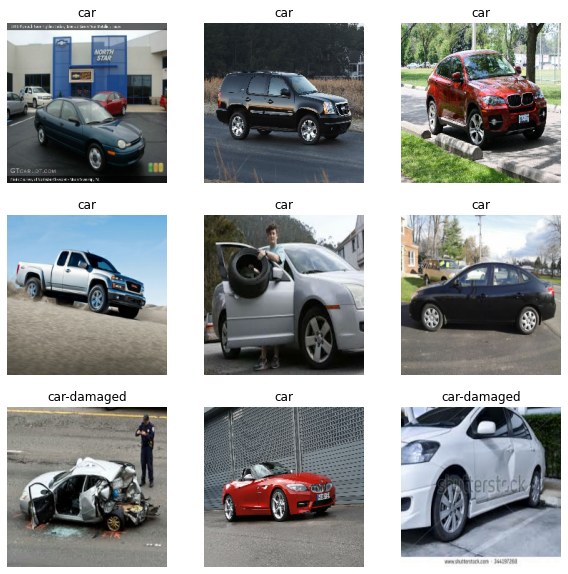

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [21]:
#Print the format of the dataset
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
#The batch size is 32, the image dimensions are 224x224 and three dimensionals (32, 224, 224, 3)

(32, 224, 224, 3)
(32, 2)


### Configure dataset for performance

In [22]:
#Optimize the datasets for performances
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Part 2 - Build the models


### Data augmentation

In this code data augmentation is achieved through layers which are added to the model

In [23]:
#Create a layer for data augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.15),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

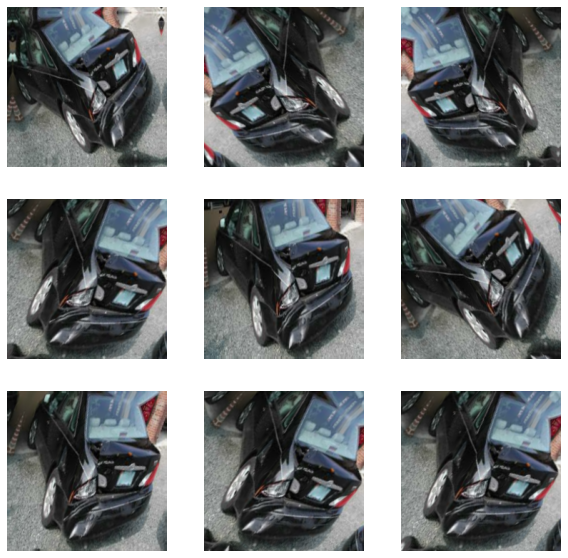

In [24]:
#Display an image of an image with the augmentation filter applied
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Build the Models
- Initialize
- Pass Data augmentation
- Rescale /255, /127.5 and 0;1 or -1;1 depending on the model transferred
- Add a GlobalMaxPooling2D, BatchNormalization, and Dropout on top of the transferred model
- Output layer - Sigmoid function (Binary output)

#### VGG16

In [25]:
from tensorflow.keras.applications import VGG16

#Make the VGG model
def make_model_VGG16(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    preprocess_input_VGG16 = keras.applications.vgg16.preprocess_input
    x = preprocess_input_VGG16(x)
    
    #We do not want the base to be trainable, otherwise we would lose all the advantagres of using pre-trained model
    conv_base_VGG16 = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
    conv_base_VGG16.trainable = False
    conv_base_VGG16.summary()

    x = conv_base_VGG16(x, training=False)

    #Rebuild top
    #Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalMaxPooling2D(name="top_GlobalMaxPooling2D")(x)
    x = layers.BatchNormalization(name="topBatchNorm")(x)

    dropout_rate = 0.5
    x = layers.Dropout(dropout_rate, name="top_dropout")(x)    

    activation = "softmax"
    units = num_classes

    outputs = layers.Dense(units, activation=activation, name="pred")(x)
 
    return keras.Model(inputs, outputs, name="VGG16_model")

#### Xception

In [26]:
from tensorflow.keras.applications import Xception

#Make the Xception model
def make_model_Xception(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    preprocess_input_Xception = keras.applications.xception.preprocess_input
    x = preprocess_input_Xception(x)
    
    #We do not want the base to be trainable, otherwise we would lose all the advantagres of using pre-trained model
    conv_base_Xception = Xception(weights='imagenet',include_top=False,input_shape=input_shape)
    conv_base_Xception.trainable = False
    conv_base_Xception.summary()

    x = conv_base_Xception(x, training=False)
    
    #Rebuild top
    #Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalMaxPooling2D(name="top_GlobalMaxPooling2D")(x)
    x = layers.BatchNormalization(name="topBatchNorm")(x)

    dropout_rate = 0.5
    x = layers.Dropout(dropout_rate, name="top_dropout")(x)    

    activation = "softmax"
    units = num_classes

    outputs = layers.Dense(units, activation=activation, name="pred")(x)

    return keras.Model(inputs, outputs, name="Xception")

#### Resnet50V2

In [27]:
from tensorflow.keras.applications import ResNet50V2

#Make the Resnet50V2 model
def make_model_Resnet50V2(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    preprocess_input_Resnet50V2 = keras.applications.resnet_v2.preprocess_input
    x = preprocess_input_Resnet50V2(x)
    
    #We do not want the base to be trainable, otherwise we would lose all the advantagres of using pre-trained model
    conv_base_Resnet50V2  = ResNet50V2(weights='imagenet',include_top=False,input_shape=input_shape)
    conv_base_Resnet50V2.trainable = False
    conv_base_Resnet50V2.summary()

    x = conv_base_Resnet50V2(x,training=False)
    
    #Rebuild top
    #Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalMaxPooling2D(name="top_GlobalMaxPooling2D")(x)
    x = layers.BatchNormalization(name="topBatchNorm")(x)

    dropout_rate = 0.5
    x = layers.Dropout(dropout_rate, name="top_dropout")(x)    

    activation = "softmax"
    units = num_classes

    outputs = layers.Dense(units, activation=activation, name="pred")(x)

    return keras.Model(inputs, outputs, name="Resnet50V2")

#### EfficientNetB0

In [28]:
from tensorflow.keras.applications import EfficientNetB0

#Make the EfficientNetB0 model
def make_model_EfficientNetB0(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    preprocess_input_EfficientNetB0 = keras.applications.efficientnet.preprocess_input
    x = preprocess_input_EfficientNetB0(x)
    
    #We do not want the base to be trainable, otherwise we would lose all the advantagres of using pre-trained model
    conv_base_EfficientNetB0  = EfficientNetB0(weights='imagenet',include_top=False,input_tensor=x)
    conv_base_EfficientNetB0.trainable = False
    conv_base_EfficientNetB0.summary()

    x = conv_base_EfficientNetB0(x, training=False)
    
    #Rebuild top
    #Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalMaxPooling2D(name="top_GlobalMaxPooling2D")(x)
    x = layers.BatchNormalization(name="topBatchNorm")(x)

    dropout_rate = 0.5
    x = layers.Dropout(dropout_rate, name="top_dropout")(x)    

    activation = "softmax"
    units = num_classes

    outputs = layers.Dense(units, activation=activation, name="pred")(x)
    
    return keras.Model(inputs, outputs, name="EfficientNetB0")

## Part 3 - Compile and Train the CNN - FUNCTION



### Compile the CNN

In [29]:
#Define a function for the compilation of the models 
#The metrics used vary between a classification with two classes and one with more than two classes

def compile_model(model_to_compile,model_arch_name):
    if num_classes == 2:
      loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
      METRICS = [
                 'accuracy',
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall'),
                 tfa.metrics.F1Score(name='f1-score',average='macro',num_classes=num_classes,threshold=0.5)
                 ]
    else:
      loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
      METRICS = [
                 'accuracy',
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall'),
                 tfa.metrics.F1Score(name='f1-score',average='macro',num_classes=num_classes,threshold=0.5),
                 tfa.metrics.F1Score(name='f1-score_perClass',num_classes=num_classes,threshold=0.5)
                 ]
    
    #Set the intiial learning rate at 0.001
    opt = Adam(lr=1e-3)
    
    model_to_compile.compile(optimizer=opt,
              loss=loss_func,
              metrics=METRICS)
    
    #Save the model plot if required to
    if (save_shape_plot == True):
      keras.utils.plot_model(model_to_compile,show_shapes=True,to_file=drive_path+model_arch_name+"_plot.png")
    return(model_to_compile)

### Training the CNN on the Training set and evaluating it on the Validation set

Callback: 

- EarlyStopping: Stop training the model if loss on validation set has not improved over 3 iterations
- ModelCheckpoint: Save the best model based on the validation accuracy
- WIP - TensorBoard: Generate the data for a tensorboard 

In [30]:
epochs = 30
#Set to 30 because we do not want early stopping because of the Visual representations, but we still use early stopping in order to restore the best weights
patience = epochs
verbose = 1

In [31]:
#Define a function to build the callbacks
def build_callback(model_name):
    callbacks_list = [
     keras.callbacks.EarlyStopping(
         monitor="val_loss",
         patience=patience,
         verbose=verbose,
         mode="auto",
         restore_best_weights=True,
     ),
      keras.callbacks.TensorBoard(
          log_dir="logs/fit/"+model_name,
          histogram_freq=1,
          embeddings_freq=1,
          )]
    if save_model == True:
      {
        callbacks_list.append(
         keras.callbacks.ModelCheckpoint(
         filepath=drive_path+""+model_name+".h5",
         monitor="val_loss",
         save_best_only=True,
     ))
      }

    return(callbacks_list)

In [32]:
def train_model(model_to_train,callbacks):
    model_to_train
    history_model_to_train = model_to_train.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )
    return(model_to_train,history_model_to_train)

### Build chart to evaluate the model training process

In [33]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics

In [34]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, model_name):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history[metric], color=colors[0], label='Train')
    plt.plot(history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()
    fig = plt.gcf()
    if(save_training_plot == True):
      fig.savefig(drive_path+model_name+"_training_plot.png", dpi=300)

### JSON export

In [35]:
def json_export(name, data):
  df = pd.DataFrame.from_dict(data)
  csv_path = drive_path+module_name+"_"+model_version+"_history_df_"+name+".csv"
  df.to_csv(csv_path, index=False)

## Part 4 - Build the desired model
Can only run one of the below, must restart the session in between the compilation of two model. The goal is to uniform the tests

### VGG16

In [36]:
keras.backend.clear_session()
model_VGG16 = make_model_VGG16(img_size+(3,),num_classes)
model_VGG16 = compile_model(model_VGG16,"VGG16")
model_VGG16.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [37]:
callbacks_VGG16 = build_callback("VGG16")
model_VGG16, history_model_VGG16 = train_model(model_VGG16, callbacks_VGG16)
# Save it under the form of a json file
if save_history == True:
  json_export("VGG16", history_model_VGG16.history)

Epoch 1/30
58/58 [==============================] - 12s 97ms/step - loss: 1.1356 - accuracy: 0.5353 - precision: 0.5353 - recall: 0.5353 - f1-score: 0.5351 - val_loss: 1.2430 - val_accuracy: 0.6804 - val_precision: 0.6804 - val_recall: 0.6804 - val_f1-score: 0.6610
Epoch 2/30
58/58 [==============================] - 3s 54ms/step - loss: 0.6667 - accuracy: 0.7540 - precision: 0.7540 - recall: 0.7540 - f1-score: 0.7537 - val_loss: 0.9909 - val_accuracy: 0.6970 - val_precision: 0.6970 - val_recall: 0.6970 - val_f1-score: 0.6803
Epoch 3/30
58/58 [==============================] - 3s 54ms/step - loss: 0.4818 - accuracy: 0.7918 - precision: 0.7918 - recall: 0.7918 - f1-score: 0.7918 - val_loss: 0.6857 - val_accuracy: 0.7713 - val_precision: 0.7713 - val_recall: 0.7713 - val_f1-score: 0.7662
Epoch 4/30
58/58 [==============================] - 3s 55ms/step - loss: 0.4639 - accuracy: 0.8000 - precision: 0.8000 - recall: 0.8000 - f1-score: 0.7997 - val_loss: 0.4604 - val_accuracy: 0.8375 - val_p

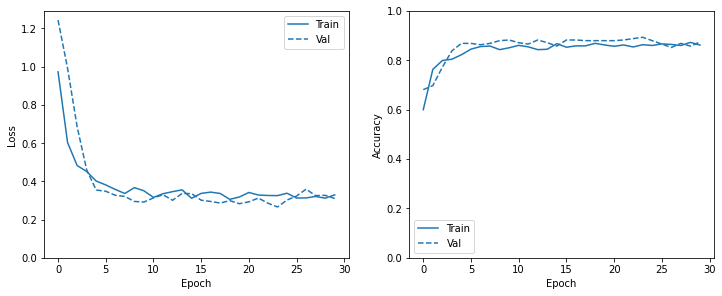

In [49]:
# Read the Json
#history_dict_VGG16 = json.load(open("history_dict_VGG16.json", 'r'))
mpl.rcParams['figure.figsize'] = (12, 10)
plot_metrics(history_model_VGG16.history,"VGG16")

### Xception

In [39]:
keras.backend.clear_session()
model_Xception = make_model_Xception(img_size+(3,),num_classes)
model_Xception = compile_model(model_Xception,"Xception")
model_Xception.summary()

83689472/83683744 [==============================] - 5s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [40]:
callbacks_Xception = build_callback("Xception")
model_Xception, history_model_Xception = train_model(model_Xception, callbacks_Xception)
# Save it under the form of a json file
if save_history == True:
  json_export("Xception", history_model_Xception.history)

Epoch 1/30
58/58 [==============================] - 9s 93ms/step - loss: 0.9637 - accuracy: 0.6351 - precision: 0.6351 - recall: 0.6351 - f1-score: 0.6350 - val_loss: 0.4692 - val_accuracy: 0.7658 - val_precision: 0.7658 - val_recall: 0.7658 - val_f1-score: 0.7578
Epoch 2/30
58/58 [==============================] - 4s 63ms/step - loss: 0.4459 - accuracy: 0.8244 - precision: 0.8244 - recall: 0.8244 - f1-score: 0.8243 - val_loss: 0.4190 - val_accuracy: 0.7989 - val_precision: 0.7989 - val_recall: 0.7989 - val_f1-score: 0.7953
Epoch 3/30
58/58 [==============================] - 3s 60ms/step - loss: 0.3868 - accuracy: 0.8437 - precision: 0.8437 - recall: 0.8437 - f1-score: 0.8432 - val_loss: 0.2456 - val_accuracy: 0.9008 - val_precision: 0.9008 - val_recall: 0.9008 - val_f1-score: 0.9008
Epoch 4/30
58/58 [==============================] - 3s 60ms/step - loss: 0.3888 - accuracy: 0.8413 - precision: 0.8413 - recall: 0.8413 - f1-score: 0.8412 - val_loss: 0.2404 - val_accuracy: 0.9146 - val_pr

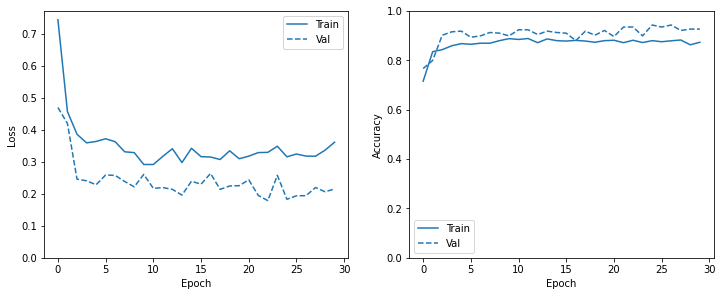

In [41]:
# Read the Json
#history_dict_Xception = json.load(open("history_dict_Xception.json", 'r'))
mpl.rcParams['figure.figsize'] = (12, 10)
plot_metrics(history_model_Xception.history,"Xception")

### Resnet50V2

In [43]:
keras.backend.clear_session()
model_Resnet50V2 = make_model_Resnet50V2(img_size+(3,),num_classes)
model_Resnet50V2 = compile_model(model_Resnet50V2,"Resnet50V2")
model_Resnet50V2.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________

In [44]:
callbacks_Resnet50V2 = build_callback("Resnet50V2")
model_Resnet50V2, history_model_Resnet50V2 = train_model(model_Resnet50V2, callbacks_Resnet50V2)
# Save it under the form of a json file
if save_history == True:
  json_export("Resnet50V2", history_model_Resnet50V2.history)

Epoch 1/30
58/58 [==============================] - 9s 82ms/step - loss: 0.7677 - accuracy: 0.7061 - precision: 0.7061 - recall: 0.7061 - f1-score: 0.7058 - val_loss: 0.8185 - val_accuracy: 0.7796 - val_precision: 0.7796 - val_recall: 0.7796 - val_f1-score: 0.7744
Epoch 2/30
58/58 [==============================] - 3s 49ms/step - loss: 0.5089 - accuracy: 0.8112 - precision: 0.8112 - recall: 0.8112 - f1-score: 0.8112 - val_loss: 0.3300 - val_accuracy: 0.8595 - val_precision: 0.8595 - val_recall: 0.8595 - val_f1-score: 0.8591
Epoch 3/30
58/58 [==============================] - 3s 49ms/step - loss: 0.3547 - accuracy: 0.8588 - precision: 0.8588 - recall: 0.8588 - f1-score: 0.8587 - val_loss: 0.3071 - val_accuracy: 0.8650 - val_precision: 0.8650 - val_recall: 0.8650 - val_f1-score: 0.8644
Epoch 4/30
58/58 [==============================] - 3s 49ms/step - loss: 0.3811 - accuracy: 0.8584 - precision: 0.8584 - recall: 0.8584 - f1-score: 0.8582 - val_loss: 0.2305 - val_accuracy: 0.9036 - val_pr

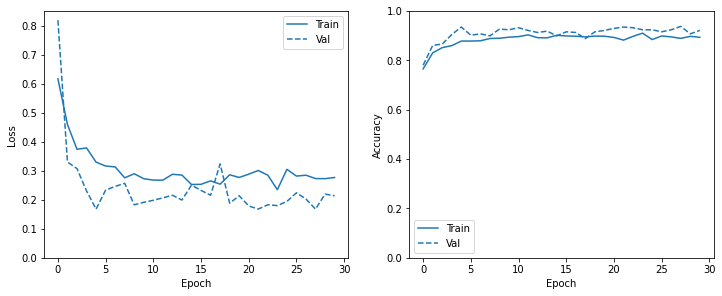

In [45]:
# Read the Json
#history_dict_Resnet50V2 = json.load(open("history_dict_Resnet50V2.json", 'r'))
mpl.rcParams['figure.figsize'] = (12, 10)
plot_metrics(history_model_Resnet50V2.history,"Resnet50V2")

### EfficientNetB0

In [47]:
keras.backend.clear_session()
model_EfficientNetB0 = make_model_EfficientNetB0(img_size+(3,),num_classes)
model_EfficientNetB0 = compile_model(model_EfficientNetB0,"EfficientNetB0")
model_EfficientNetB0.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           sequential[3][0]                 
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
____________________

In [48]:
callbacks_EfficientNetB0 = build_callback("EfficientNetB0")
model_EfficientNetB0, history_model_EfficientNetB0 = train_model(model_EfficientNetB0, callbacks_EfficientNetB0)
# Save it under the form of a json file
if save_history == True:
  json_export("EfficientNetB0", history_model_EfficientNetB0.history)

Epoch 1/30
58/58 [==============================] - 11s 85ms/step - loss: 1.0649 - accuracy: 0.5946 - precision: 0.5946 - recall: 0.5946 - f1-score: 0.5938 - val_loss: 1.2495 - val_accuracy: 0.6584 - val_precision: 0.6584 - val_recall: 0.6584 - val_f1-score: 0.6272
Epoch 2/30
58/58 [==============================] - 2s 41ms/step - loss: 0.4443 - accuracy: 0.8262 - precision: 0.8262 - recall: 0.8262 - f1-score: 0.8261 - val_loss: 0.6026 - val_accuracy: 0.7769 - val_precision: 0.7769 - val_recall: 0.7769 - val_f1-score: 0.7706
Epoch 3/30
58/58 [==============================] - 2s 40ms/step - loss: 0.3830 - accuracy: 0.8551 - precision: 0.8551 - recall: 0.8551 - f1-score: 0.8549 - val_loss: 0.3718 - val_accuracy: 0.8430 - val_precision: 0.8430 - val_recall: 0.8430 - val_f1-score: 0.8416
Epoch 4/30
58/58 [==============================] - 2s 42ms/step - loss: 0.3500 - accuracy: 0.8763 - precision: 0.8763 - recall: 0.8763 - f1-score: 0.8762 - val_loss: 0.2490 - val_accuracy: 0.8898 - val_p

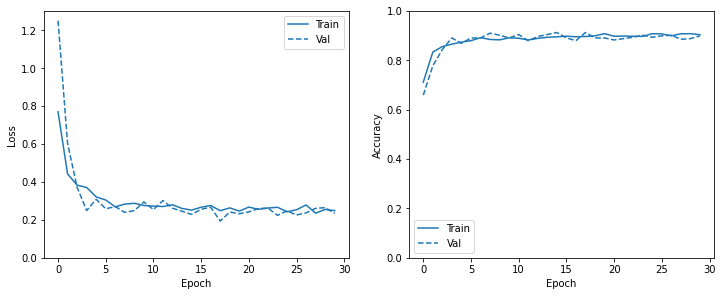

In [51]:
# Read the Json
#history_dict_EfficientNetB0 = json.load(open("history_dict_EfficientNetB0.json", 'r'))
mpl.rcParams['figure.figsize'] = (12, 10)
plot_metrics(history_model_EfficientNetB0.history,"EfficientNetB0")

In [52]:
history_model_EfficientNetB0.history

{'accuracy': [0.710869550704956,
  0.832608699798584,
  0.854891300201416,
  0.864673912525177,
  0.872826099395752,
  0.8788043260574341,
  0.8907608985900879,
  0.883695662021637,
  0.8820652365684509,
  0.8902173638343811,
  0.8885869383811951,
  0.8815217614173889,
  0.8880434632301331,
  0.8923913240432739,
  0.894565224647522,
  0.89673912525177,
  0.894565224647522,
  0.895652174949646,
  0.898369550704956,
  0.907065212726593,
  0.89673912525177,
  0.897282600402832,
  0.89673912525177,
  0.896195650100708,
  0.907065212726593,
  0.905978262424469,
  0.898369550704956,
  0.906521737575531,
  0.907065212726593,
  0.9027174115180969],
 'f1-score': [0.710861086845398,
  0.8325960636138916,
  0.8548500537872314,
  0.8646527528762817,
  0.8728259801864624,
  0.8787999749183655,
  0.8907535672187805,
  0.8836921453475952,
  0.8820624351501465,
  0.8902090787887573,
  0.8885853290557861,
  0.881441056728363,
  0.8880434036254883,
  0.892366349697113,
  0.8945591449737549,
  0.89673715

history_model_

# Tensorboard

In [ ]:
#https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tbdev_getting_started.ipynb#scrollTo=Ycz766H-zSwh

#!rm -rf ./logs/fit/VGG16_20201217-113236
#!tensorboard dev list
#!tensorboard dev delete --experiment_id Br3ndmwmTV6gJhj0FoOEDg

In [53]:
#Update to Tensorboard
!tensorboard dev upload --logdir ./logs \
  --name "Module 1 - Model Selection - vF" \
  --description "Max Pooling, Batch Normalization, Dropout = 0.5" \
  --one_shot

2021-01-12 16:20:26.243285: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&sc

## Access Tensorboard and build chart

https://www.tensorflow.org/tensorboard/dataframe_api

In [54]:
experiment_id = "A61FOot4RCyF9woTWORmAg"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
print(df["run"].unique())
print(df["tag"].unique())

['fit/EfficientNetB0/train' 'fit/EfficientNetB0/validation'
 'fit/Resnet50V2/train' 'fit/Resnet50V2/validation' 'fit/VGG16/train'
 'fit/VGG16/validation' 'fit/Xception/train' 'fit/Xception/validation']
['epoch_accuracy' 'epoch_f1-score' 'epoch_loss' 'epoch_precision'
 'epoch_recall']


In [55]:
dfw = experiment.get_scalars(pivot=True) 
dfw

,run,step,epoch_accuracy,epoch_f1-score,epoch_loss,epoch_precision,epoch_recall
0,fit/EfficientNetB0/train,0,0.710870,0.710861,0.769702,0.710870,0.710870
1,fit/EfficientNetB0/train,1,0.832609,0.832596,0.441987,0.832609,0.832609
2,fit/EfficientNetB0/train,2,0.854891,0.854850,0.382893,0.854891,0.854891
3,fit/EfficientNetB0/train,3,0.864674,0.864653,0.370531,0.864674,0.864674
4,fit/EfficientNetB0/train,4,0.872826,0.872826,0.320883,0.872826,0.872826
...,...,...,...,...,...,...,...
235,fit/Xception/validation,25,0.933884,0.933880,0.193569,0.933884,0.933884
236,fit/Xception/validation,26,0.942149,0.942133,0.193889,0.942149,0.942149
237,fit/Xception/validation,27,0.920110,0.920108,0.219358,0.920110,0.920110
238,fit/Xception/validation,28,0.925620,0.925611,0.206199,0.925620,0.925620


In [56]:
csv_path = drive_path+module_name+"_"+model_version+"_experiment.csv"
dfw.to_csv(csv_path, index=False)
dfw_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(dfw_roundtrip, dfw)

Text(0.5, 1.0, 'loss')

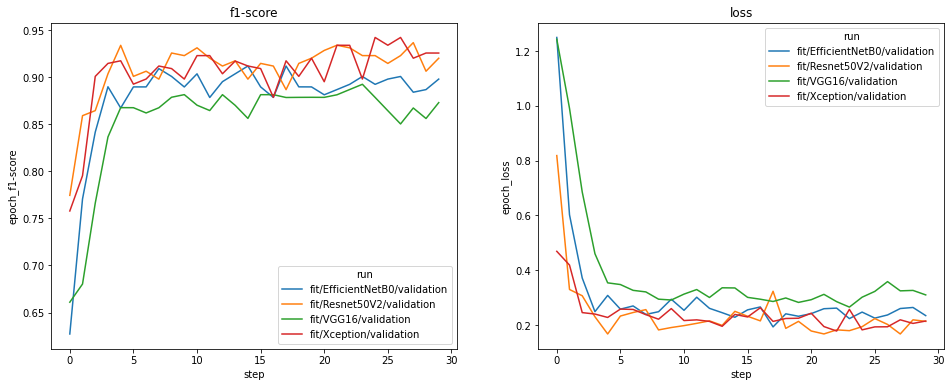

In [57]:
# Filter the DataFrame to only validation data, which is what the subsequent
# analyses and visualization will be focused on.
dfw_validation = dfw[dfw.run.str.endswith("/validation")]
# Get the optimizer value for each row of the validation DataFrame.
optimizer_validation = dfw_validation.run.apply(lambda run: run.split(",")[0])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=dfw_validation, x="step", y="epoch_f1-score", 
             hue=optimizer_validation).set_title("f1-score")
plt.subplot(1, 2, 2)
sns.lineplot(data=dfw_validation, x="step", y="epoch_loss",
             hue=optimizer_validation).set_title("loss")

In [58]:
dfw_validation.groupby('run')['epoch_f1-score'].nlargest(1,)

run                               
fit/EfficientNetB0/validation  44     0.911813
fit/Resnet50V2/validation      117    0.936637
fit/VGG16/validation           173    0.892402
fit/Xception/validation        234    0.942133
Name: epoch_f1-score, dtype: float64

### EfficientNet-B0

In [59]:
dfw_EfficientNetB0 = dfw[dfw.run.str.startswith("fit/EfficientNetB0")]

Text(0.5, 1.0, 'loss')

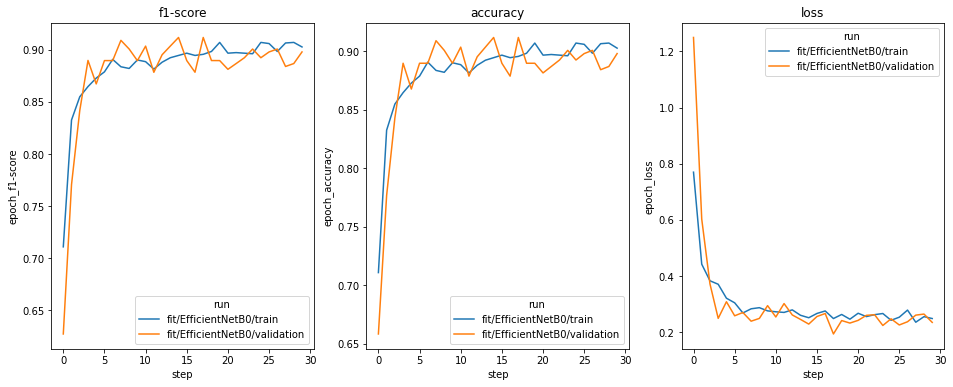

In [60]:
# Get the optimizer value for each row of the validation DataFrame.
optimizer_validation = dfw_EfficientNetB0.run.apply(lambda run: run.split(",")[0])

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
sns.lineplot(data=dfw_EfficientNetB0, x="step", y="epoch_f1-score", 
             hue=optimizer_validation).set_title("f1-score")
plt.subplot(1, 3, 2)
sns.lineplot(data=dfw_EfficientNetB0, x="step", y="epoch_accuracy",
             hue=optimizer_validation).set_title("accuracy")
plt.subplot(1, 3, 3)
sns.lineplot(data=dfw_EfficientNetB0, x="step", y="epoch_loss",
             hue=optimizer_validation).set_title("loss")

# Load and evaluate models

## Part 1 - Load the model and evaluate its accuracy

In [61]:
#model = model_VGG16
#model_name = "VGG16"
#model = model_Xception
#model_name = "Xception"
#model = model_Resnet50V2
#model_name = "Resnet50V2"
model = model_EfficientNetB0
model_name = "EfficientNetB0"


In [62]:
def model_accuracy():
  loss, acc, prec, reca, f1 = model.evaluate(test_ds)
  print('Restored model '+model_name+', accuracy: {:5.2f}%'.format(100*acc))
  print(model.predict(test_ds).shape)

In [63]:
#from https://www.tensorflow.org/tutorials/keras/save_and_load
#model_VGG16 = tf.keras.models.load_model('V2_TRANSFER_VGG16_REDUCED.h5')
# Check its architecture
# model_vgg.summary()
# model_xception.summary()

model_accuracy()

3/3 [==============================] - 2s 156ms/step - loss: 0.2753 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8750 - f1-score: 0.8745
Restored model EfficientNetB0, accuracy: 87.50%
(96, 2)


## Part 2 - Proceed to multiple predictions


In [64]:
def model_predict():
  #Retrieve a batch of images from the test set
  image_batch, label_batch = test_ds.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch)

  #print('Predictions:\n', predictions)
  #print('Labels:\n', label_batch)

  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    x = class_names[np.argmax(label_batch[i])]
    y = class_names[np.argmax(predictions[i])]
    plt.title("Actual:"+ x +"\nPredicted:"+ y +"")
    plt.axis("off")
  return predictions

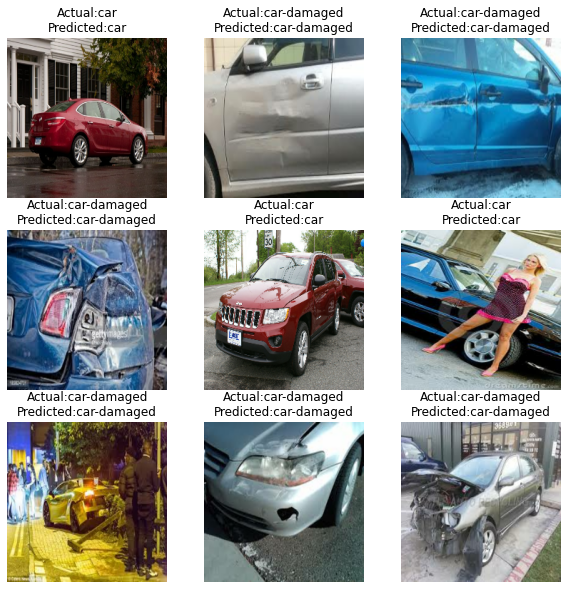

In [65]:
predictions = model_predict()
#Retrieve a batch of images from the test set

In [66]:
#Check
np.sum(predictions, axis=1)

array([1.        , 1.        , 1.        , 1.0000001 , 1.        ,
       0.99999994, 1.        , 0.99999994, 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.0000001 , 1.        ], dtype=float32)

## Part 3 - Single Prediction

In [67]:
def model_predict_single():

  prediction = model.predict(img_array)

  #print(f"The alogirthm says this image is:\n {prediction[0,0]:.2%} {class_names[0]}\n and {prediction[0,1]:.2%} {class_names[1]}\n and {prediction[0,2]:.2%} {class_names[2]}\n")
  img.show()

The algorithm says this image is:
 3.91% car
 and 96.09% car-damaged



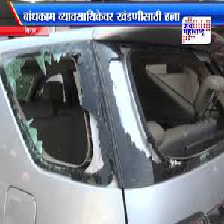

In [69]:
img_path = "/content/Dataset_v1_bin_damage/car-damaged/car-damaged_0.jpg"

img = keras.preprocessing.image.load_img(
      img_path, target_size=img_size
  )

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

prediction = model.predict(img_array)

print(f"The algorithm says this image is:\n {prediction[0,0]:.2%} {class_names[0]}\n and {prediction[0,1]:.2%} {class_names[1]}\n")
img
